# Molecular dynamics with franken and ASE

In this notebook we show how to perform MD with a trained franken model.
Once again we use the water dataset as a simple example, and finetune the [MACE-MP0 foundation model](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) which was trained on the materials-project dataset to accurately predict a potential field at a high level of theory.

In [1]:
try:
    import franken
except ImportError:
    %pip install franken[mace]
    import franken

In [ ]:
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import ase
import ase.md
import ase.md.velocitydistribution
from ase.geometry.rdf import get_recommended_r_max, get_rdf

from franken.calculators import FrankenCalculator
from franken.datasets.registry import DATASET_REGISTRY
from franken.backbones.utils import CacheDir
from franken.autotune import autotune
from franken.config import (
    MaceBackboneConfig,
    MultiscaleGaussianRFConfig,
    DatasetConfig,
    SolverConfig,
    HPSearchConfig,
    AutotuneConfig,
)

/home/lbonati@iit.local/software/miniforge3-mamba/envs/franken/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run autotune to train a franken model
The first step is to obtain a trained franken model, with which to perform the MD.

We do this using the `autotune` interface, for which [a dedicated tutorial](./autotune.ipynb) is available.

In [3]:
gnn_config = MaceBackboneConfig(
    path_or_id="mace_mp/small",
    interaction_block=2,
)

dataset_cfg = DatasetConfig(name="water", max_train_samples=8, 
                            # or specify train/val/test paths:
                            # train_path="train.xyz", 
                            # val_path="val.xyz", 
                            )
rf_config = MultiscaleGaussianRFConfig(
    num_random_features=512,
    length_scale_low=8,
    length_scale_high=32,
    length_scale_num=4,
    rng_seed=42,
)
solver_cfg = SolverConfig(
    l2_penalty=HPSearchConfig(start=-10, stop=-5, num=5, scale='log'),  # equivalent of numpy.logspace
    force_weight=HPSearchConfig(start=0.01, stop=0.99, num=5, scale='linear'),  # equivalent of numpy.linspace
)
autotune_cfg = AutotuneConfig(
    dataset=dataset_cfg,
    solver=solver_cfg,
    backbone=gnn_config,
    rfs=rf_config,
    seed=42,
    jac_chunk_size='auto',
    run_dir="./results",
)

In [4]:
run_path = autotune(autotune_cfg)

console_logging_level: INFO
dtype: float64
jac_chunk_size: auto
rf_normalization: leading_eig
run_dir: ./results
save_every_model: False
save_fmaps: False
scale_by_species: True
seed: 42
backbone:
    family: mace
    interaction_block: 2
    path_or_id: mace_mp/small
dataset:
    max_train_samples: 8
    name: water
    test_path: null
    train_path: null
    val_path: null
rfs:
    length_scale_high: 32
    length_scale_low: 8
    length_scale_num: 4
    num_random_features: 512
    rf_type: multiscale-gaussian
    rng_seed: 42
    use_offset: true
solver:
    force_weight:
      num: 5
      scale: linear
      start: 0.01
      stop: 0.99
      value: null
      values: null
    l2_penalty:
      num: 5
      scale: log
      start: -10
      stop: -5
      value: null
      values: null

2026-01-25 14:11:06.787 INFO (rank 0): Initializing default cache directory at /home/lbonati@iit.local/.franken
2026-01-25 14:11:06.793 INFO (rank 0): Run folder: results/run_260125_141106_19bfaf

Computing dataset statistics: 100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


2026-01-25 14:11:15.739 INFO (rank 0): jacobian chunk size automatically set to 32
2026-01-25 14:11:46.246 WARNING (rank 0): `leading_eig` normalization has high memory usage. If you encounter OOM errors try to disable it.
2026-01-25 14:12:32.102 INFO (rank 0): Trial   1 | rf_type: multiscale-gaussian | num_random_features:   512   | length_scale_low:    8    | length_scale_high:   32    | length_scale_num:    4    | use_offset:  True   | rng_seed:   42    | Best trial 1 (energy 0.32 meV/atom - forces 25.1 meV/Ang)


## Run molecular dynamics

Next we can run the molecular dynamics simulation.

Most of the code below is boiler-plate for the simulation 

We start by defining some parameters of the molecular dynamics:
 - The MD length (in nanoseconds)
 - The timestep (in femtoseconds)
 - The simulation temperature (in kelvin)
 - Friction of the Langevin integrator (in units 1/fs)

In [5]:
md_length_ns = 0.01
timestep_fs = 0.5
temperature_K = 325
friction = 0.01
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Load the initial configuration: a random one taken from the water training set

In [6]:
data_path = DATASET_REGISTRY.get_path("water", "train", CacheDir.get())
initial_configuration = ase.io.read(data_path, index=567)

Initialize the `trajectory` object. It will be used to save the outputs of the MD.

In [7]:
md_path = run_path / "md"
md_path.mkdir(exist_ok=True)
# Trajectory will contain the output data
trajectory_path = md_path / f"md_output.traj"
trajectory = ase.io.Trajectory(trajectory_path, "w", initial_configuration)

Initialize the calculator object which wraps the `franken` model we have learned previously.

In [8]:
model_path = run_path / "best_ckpt.pt"
calc = FrankenCalculator(model_path, device=device)
initial_configuration.calc = calc

Initialize ASE-specific MD-related objects: 
 - the velocity initialization
 - the Langevin integrator 
 - and a logger to record results.

In [9]:
ase.md.velocitydistribution.MaxwellBoltzmannDistribution(
    atoms=initial_configuration,
    temperature_K=temperature_K
)
integrator = ase.md.Langevin(
    atoms=initial_configuration,
    temperature_K=temperature_K,
    friction=friction / ase.units.fs,
    timestep=timestep_fs * ase.units.fs
)
md_logger = ase.md.MDLogger(
    integrator,
    initial_configuration,
    sys.stdout,  # log directly to console
    header=True,
    stress=False,
    peratom=False,
)
integrator.attach(md_logger, interval=2000)
integrator.attach(trajectory.write, interval=20)

Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]


Finally run the MD for the desired number of time-steps

In [10]:
integrator.run(md_length_ns * 1e6 / timestep_fs)

0.0000         -915.772     -923.371        7.600   311.1
1.0000         -914.456     -922.815        8.359   342.1
2.0000         -915.416     -923.301        7.884   322.7
3.0000         -914.253     -922.529        8.276   338.8
4.0000         -914.204     -921.829        7.624   312.1
5.0000         -915.925     -923.492        7.567   309.7
6.0000         -914.147     -922.450        8.302   339.8
7.0000         -914.538     -922.829        8.291   339.4
8.0000         -915.881     -923.429        7.548   309.0
9.0000         -915.414     -923.459        8.045   329.3
10.0000        -915.183     -922.423        7.240   296.3


True

### Analyse MD results

The trajectory can be loaded with ASE, we can then plot the radial-distribution function of the simulation.

In [11]:
traj = ase.io.read(trajectory_path, index=":")
# Skip first time-step which is just the initial configuration
traj = traj[1:]
print(f"Loaded MD trajectory of length {len(traj)}")

Loaded MD trajectory of length 1000


We compute the RDF of the O-O atoms within the trajectory, and then compute the average and plot it.
We're using ASE's `get_rdf` for the actual distance calculations.
The trajectory is very short, so the RDF is very noisy, but by increasing the simulation time it's easy to get a clean curve.

In [12]:
equilibration_fs = 0.5 * 100  # deliberately short
nbins_per_angstrom = 50

# Skip the beginning of the trajectory where simulation is not at equilibrium
traj_len_fs = timestep_fs * len(traj)
# equilibration time / 100 (sampling interval)
traj_eq = traj[int(equilibration_fs / timestep_fs / 20) :]

rmax = 6.3
nbins = int(rmax * nbins_per_angstrom)

element_pair = (8, 8)  # O-O distances

# Compute the average RDF
rdf_list = []
for i, atoms in enumerate(traj_eq):
    rdf, radii = get_rdf(
        atoms,
        rmax,
        nbins,
        no_dists=False,
        elements=element_pair,
    )
    rdf_list.append(rdf)
avg_rdf = np.mean(rdf_list, axis=0)

(1.5, 6.3)

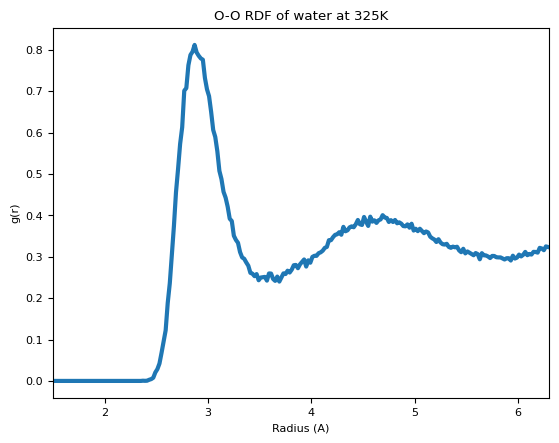

In [13]:
fig, ax = plt.subplots()
ax.plot(radii, avg_rdf, lw=3)
ax.set_xlabel("Radius (A)")
ax.set_ylabel("g(r)")
ax.set_title(f"O-O RDF of water at {temperature_K}K")
ax.set_xlim([1.5, rmax])